# LegacyHalos Parent Sample QAplots

Generate a variety of QAplots from the parent sample.

### Imports

In [1]:
import os
import warnings
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import ticker

from astropy.io import fits
from astropy.table import Table

In [2]:
plt.style.use('seaborn-talk')
%matplotlib inline

### Specify the LegacyHalos path and parent files names and read the data.

In [3]:
legacyhalos_dir = os.getenv('LEGACYHALOS_DIR')
parentfile = os.path.join(legacyhalos_dir, 'legacyhalos-parent.fits')
parentupennfile = os.path.join(legacyhalos_dir, 'legacyhalos-upenn-parent.fits')

In [17]:
sdssphot = Table(fits.getdata(parentfile, extname='SDSSPHOT'))

In [18]:
rm = Table(fits.getdata(parentfile, extname='REDMAPPER'))

In [19]:
lsphot = Table(fits.getdata(parentfile, extname='LSPHOT'))

### Visualize the footprint and redshift distribution.

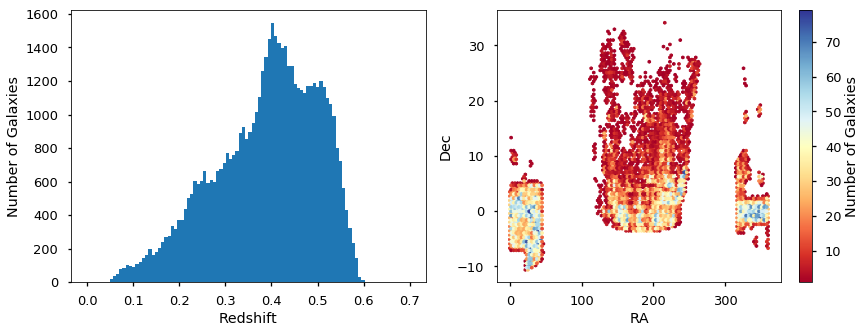

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

_ = ax1.hist(rm['Z'], bins=100, range=(0, 0.7))
ax1.set_xlabel('Redshift')
ax1.set_ylabel('Number of Galaxies')

hb = ax2.hexbin(sdssphot['RA'], sdssphot['DEC'], mincnt=1,
                cmap=plt.cm.get_cmap('RdYlBu'))
cb = plt.colorbar(hb)
cb.set_label('Number of Galaxies')
ax2.set_xlabel('RA')
ax2.set_ylabel('Dec')

### Richness-redshift and halo mass-redshift relations.

In [8]:
def lambda2mhalo(richness, redshift=0.3, Saro=False):
    """
    Convert cluster richness, lambda, to halo mass, given various 
    calibrations.
    
      * Saro et al. 2015: Equation (7) and Table 2 gives M(500).
      * Melchior et al. 2017: Equation (51) and Table 4 gives M(200).
      * Simet et al. 2017: 
    
    Other SDSS-based calibrations: Li et al. 2016; Miyatake et al. 2016; 
    Farahi et al. 2016; Baxter et al. 2016.

    TODO: Return the variance!

    """
    if Saro:
        pass
    
    # Melchior et al. 2017 (default)
    logM0, Flam, Gz, lam0, z0 = 14.371, 1.12, 0.18, 30.0, 0.5
    Mhalo = 10**logM0 * (richness / lam0)**Flam * ( (1 + redshift) / (1 + z0) )**Gz
    
    return Mhalo

In [9]:
mhalo = np.log10( lambda2mhalo(rm['LAMBDA_CHISQ'], rm['Z']) )

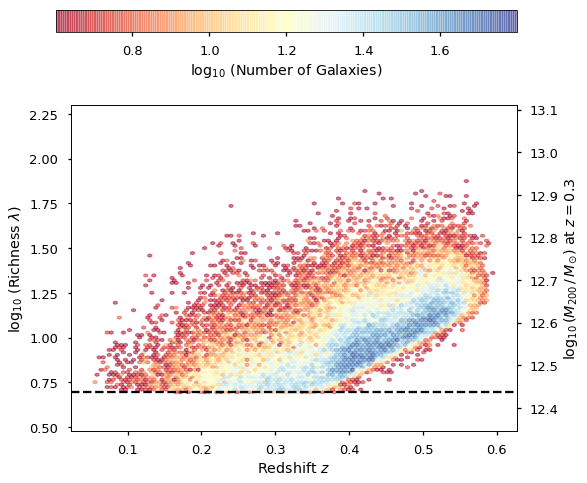

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

hb = ax.hexbin(rm['Z'], np.log10(rm['LAMBDA_CHISQ']), mincnt=3,
               cmap=plt.cm.get_cmap('RdYlBu'), alpha=0.5, bins='log')
ax.set_xlabel('Redshift $z$')
ax.set_ylabel(r'$\log_{10}$ (Richness $\lambda$)')
ax.set_xlim(0, 0.6)
ymin, ymax = np.log10(3), 2.3
ax.set_ylim(ymin, ymax)
ax.axhline(y=np.log10(5), ls='--', color='k')

cax = fig.add_axes([0.1, 1.05, 0.8, 0.05])
cb = plt.colorbar(hb, orientation='horizontal', cax=cax)
cb.set_label(r'$\log_{10}$ (Number of Galaxies)')       

ax2 = ax.twinx()
ax2.set_ylabel(r'$\log_{10}\, (M_{200}\, /\, M_{\odot})$ at $z=0.3$')
ax2.set_ylim( np.log10(lambda2mhalo(ymin)), np.log10(lambda2mhalo(ymax)) )
ax2.plot([],[])

### Compare LS/SDSS magnitudes and colors.

In [51]:
def unextinct_sdssphot(phot):
    """Correct SDSS photometry for MW extinction and compute colors."""
    dtype = [('g', 'f4'), ('r', 'f4'), ('z', 'f4'), 
             ('W1', 'f4'), ('W2', 'f4'), 
             ('gr', 'f4'), ('rz', 'f4')]
    result = np.zeros(len(phot), dtype=dtype)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        ugriz = 22.5 - 2.5 * np.log10(phot['CMODELMAGGIES']) - phot['EXTINCTION']
    
        result['g'] = ugriz[:, 1]
        result['r'] = ugriz[:, 2]
        result['z'] = ugriz[:, 4]
        result['gr'] = result['g'] - result['r']
        result['rz'] = result['r'] - result['z']
        
    return Table(result)

In [12]:
def unextinct_lsphot(phot):
    """Correct LS photometry for MW extinction and compute colors."""
    dtype = [('g', 'f4'), ('r', 'f4'), ('z', 'f4'), 
             ('W1', 'f4'), ('W2', 'f4'), 
             ('gr', 'f4'), ('rz', 'f4')]
    result = np.zeros(len(phot), dtype=dtype)

    g = phot['FLUX_G'] / phot['MW_TRANSMISSION_G']
    r = phot['FLUX_R'] / phot['MW_TRANSMISSION_R']
    z = phot['FLUX_Z'] / phot['MW_TRANSMISSION_Z']
    W1 = phot['FLUX_W1'] / phot['MW_TRANSMISSION_W1']
    W2 = phot['FLUX_W2'] / phot['MW_TRANSMISSION_W2']
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        result['g'] = 22.5 - 2.5 * np.log10(g)
        result['r'] = 22.5 - 2.5 * np.log10(r)
        result['z'] = 22.5 - 2.5 * np.log10(z)
        result['W1'] = 22.5 - 2.5 * np.log10(W1)
        result['W2'] = 22.5 - 2.5 * np.log10(W2)
        result['gr'] = result['g'] - result['r']
        result['rz'] = result['r'] - result['z']
        
    return Table(result)

In [13]:
ls = unextinct_lsphot(lsphot)

In [14]:
sdss = unextinct_sdssphot(sdssphot)

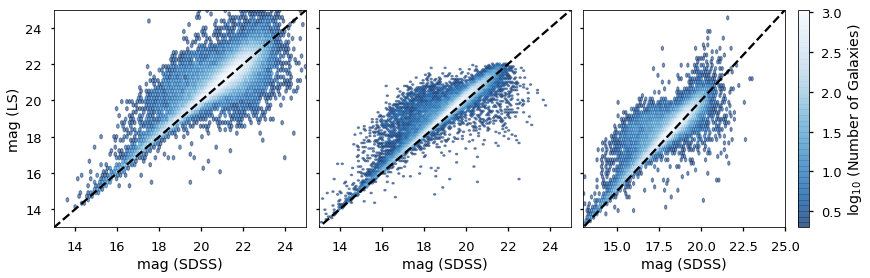

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for ii, band in enumerate(('g', 'r', 'z')):
    hb = ax[ii].hexbin(ls[band], sdss[band], mincnt=1,
                cmap=plt.cm.Blues_r, alpha=0.5, bins='log')
    ax[ii].set_xlim(13, 25)
    ax[ii].set_ylim(13, 25)
    #ax[ii].legend(loc='upper left')
    ax[ii].plot([10, 30], [10, 30], color='k', ls='--')
    ax[ii].set_xlabel('mag (SDSS)')
ax[0].set_ylabel('mag (LS)')
cb = plt.colorbar(hb)
cb.set_label(r'$\log_{10}$ (Number of Galaxies)')
fig.subplots_adjust(wspace=0.05)

### Compare LS/UPenn magnitudes and colors.

In [21]:
lsupenn = Table(fits.getdata(parentupennfile, extname='LSPHOT'))

In [49]:
sdssupenn = Table(fits.getdata(parentupennfile, extname='SDSSPHOT'))

In [23]:
upenn = Table(fits.getdata(parentupennfile, extname='UPENN'))
upenn.colnames

['GALCOUNT',
 'FLAGSEREXP',
 'MSTAR_TAB5_PYMORPH',
 'MSTAR_TAB5_TRUNCATED',
 'MSTAR_TAB3_PYMORPH',
 'MSTAR_TAB3_TRUNCATED',
 'MSTAR_TAB5_MENDEL',
 'MSTAR_TAB3_MENDEL',
 'MSTAR_TAB5_CMODEL',
 'MSTAR_TAB3_CMODEL',
 'G_M_TOT',
 'G_M_APER',
 'G_BT',
 'G_R_TOT',
 'G_BA_TOT',
 'G_BT_APER',
 'G_XCTR_BULGE',
 'G_XCTR_BULGE_ERR',
 'G_YCTR_BULGE',
 'G_YCTR_BULGE_ERR',
 'G_M_BULGE',
 'G_M_BULGE_ERR',
 'G_R_BULGE',
 'G_R_BULGE_ERR',
 'G_N_BULGE',
 'G_N_BULGE_ERR',
 'G_BA_BULGE',
 'G_BA_BULGE_ERR',
 'G_PA_BULGE',
 'G_PA_BULGE_ERR',
 'G_XCTR_DISK',
 'G_XCTR_DISK_ERR',
 'G_YCTR_DISK',
 'G_YCTR_DISK_ERR',
 'G_M_DISK',
 'G_M_DISK_ERR',
 'G_R_DISK',
 'G_R_DISK_ERR',
 'G_N_DISK',
 'G_N_DISK_ERR',
 'G_BA_DISK',
 'G_BA_DISK_ERR',
 'G_PA_DISK',
 'G_PA_DISK_ERR',
 'G_GALSKY',
 'G_GALSKY_ERR',
 'G_CHI2NU',
 'G_FINALFLAG',
 'G_AUTOFLAG',
 'G_PYFLAG',
 'G_PYFITFLAG',
 'R_M_TOT',
 'R_M_APER',
 'R_BT',
 'R_R_TOT',
 'R_BA_TOT',
 'R_BT_APER',
 'R_XCTR_BULGE',
 'R_XCTR_BULGE_ERR',
 'R_YCTR_BULGE',
 'R_YCTR_BULGE_ERR

In [52]:
lsupennphot = unextinct_lsphot(lsupenn)
sdssupennphot = unextinct_sdssphot(sdssupenn)

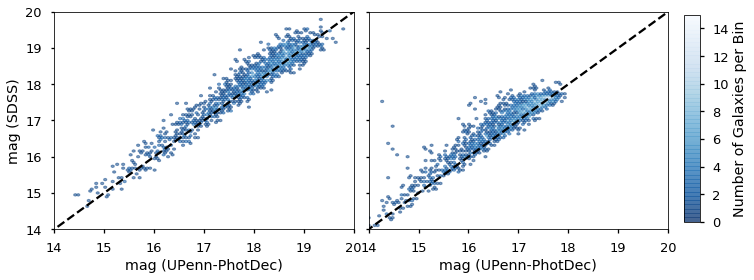

In [84]:
minmag, maxmag = 14, 20
fig, ax = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
for ii, band in enumerate(('g', 'r')):
    hb = ax[ii].hexbin(upenn['{}_M_TOT'.format(band.upper())], sdssupennphot[band], 
                       mincnt=1, cmap=plt.cm.Blues_r, alpha=0.5, #bins='log',
                       extent=(minmag, maxmag, minmag, maxmag),
                       vmin=0, vmax=15)
    ax[ii].set_xlim(minmag, maxmag)
    ax[ii].set_ylim(minmag, maxmag)
    ax[ii].plot([10, 30], [10, 30], color='k', ls='--')
    ax[ii].set_xlabel('mag (UPenn-PhotDec)')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.72])
cb = plt.colorbar(hb, cax=cax)
cb.set_label('Number of Galaxies per Bin') 
ax[0].set_ylabel('mag (SDSS)')
fig.subplots_adjust(wspace=0.05)

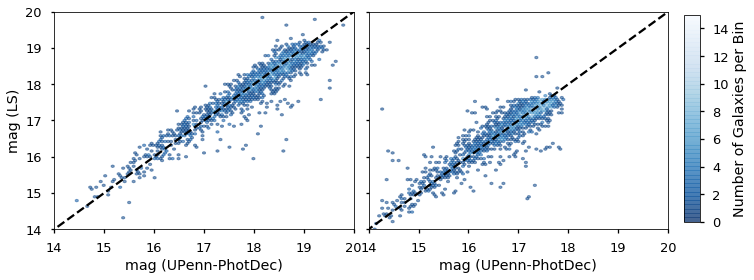

In [83]:
minmag, maxmag = 14, 20
fig, ax = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
for ii, band in enumerate(('g', 'r')):
    hb = ax[ii].hexbin(upenn['{}_M_TOT'.format(band.upper())], lsupennphot[band], 
                       mincnt=1, cmap=plt.cm.Blues_r, alpha=0.5, #bins='log',
                       extent=(minmag, maxmag, minmag, maxmag),
                       vmin=0, vmax=15)
    ax[ii].set_xlim(minmag, maxmag)
    ax[ii].set_ylim(minmag, maxmag)
    ax[ii].plot([10, 30], [10, 30], color='k', ls='--')
    ax[ii].set_xlabel('mag (UPenn-PhotDec)')
cax = fig.add_axes([0.92, 0.15, 0.02, 0.72])
cb = plt.colorbar(hb, cax=cax)
cb.set_label('Number of Galaxies per Bin')
#cb.set_label(r'$\log_{10}$ (Number of Galaxies)')    
ax[0].set_ylabel('mag (LS)')
fig.subplots_adjust(wspace=0.05)